<a href="https://colab.research.google.com/github/terri-pietka-ds/HCD-Imaging-Classification/blob/main/T_Pietka_HCD_Modeling_using_SE_block%26CBAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

histopathologic_cancer_detection_path = kagglehub.competition_download('histopathologic-cancer-detection')

print('Data source import complete.')


100%|██████████| 6.31G/6.31G [05:39<00:00, 20.0MB/s]

Extracting files...


Data source import complete.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install specific tensforflow version for Kaggle compatibility
!pip install tensorflow==2.16.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 106.4 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.16.1 

# Import libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils import class_weight

from itertools import cycle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Layer, Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization,
    GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Multiply, Concatenate, LeakyReLU
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
from tensorflow.keras.saving import register_keras_serializable


# Set directories, load csv

In [ ]:
# Paths to data
train_images = '/root/.cache/kagglehub/competitions/histopathologic-cancer-detection/train/'
label_csv = '/root/.cache/kagglehub/competitions/histopathologic-cancer-detection/train_labels.csv'

# Read labels
full_df = pd.read_csv(label_csv)
full_df['id'] = full_df['id'] + '.tif'
full_df['label'] = full_df['label'].astype(str)

# Filtering function to remove images that are mostly white or black
def filter_images(image_dir, image_ids, black_thresh=0.90, white_thresh=0.90):
    valid_ids = []

    for img_id in image_ids:
        img_path = os.path.join(image_dir, img_id)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            continue  # Skip unreadable images

        # Normalize pixel values to [0, 1]
        img = img / 255.0

        # Calculate black and white pixel ratios
        black_ratio = np.sum(img < 0.1) / img.size
        white_ratio = np.sum(img > 0.9) / img.size

        # Keep images that are NOT mostly black or white
        if black_ratio < black_thresh and white_ratio < white_thresh:
            valid_ids.append(img_id)

    return valid_ids

# Filter the images
valid_image_ids = filter_images(train_images, full_df['id'].tolist())
print(f"Number of valid images: {len(valid_image_ids)}")

# Update full_df to include only valid images
filtered_df = full_df[full_df['id'].isin(valid_image_ids)].reset_index(drop=True)
print(f"Updated dataframe shape: {filtered_df.shape}")


Number of valid images: 217330
Updated dataframe shape: (217330, 2)


In [ ]:
filtered_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


# Determine label frequency

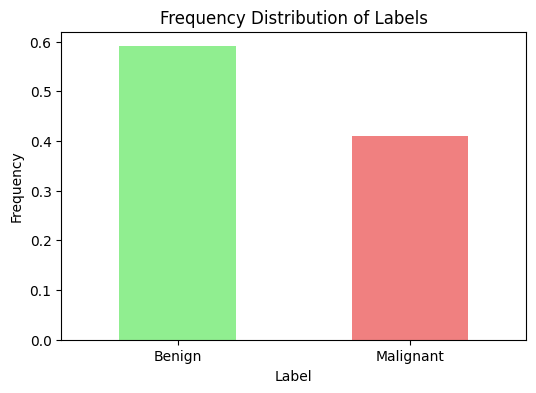

In [ ]:
# Calculate frequency distribution
frequency_distribution = (filtered_df.label.value_counts() / len(filtered_df)).to_frame()

# Plotting the frequency distribution as a bar chart
plt.figure(figsize=(6, 4))
colors = ['lightgreen', 'lightcoral']  # light green for benign, light red for malignant

# Plotting bar chart with specified colors
frequency_distribution.iloc[:, 0].plot(kind='bar', color=colors)

# Customizing chart
plt.title('Frequency Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['Benign', 'Malignant'], rotation=0)

# Show the plot
plt.show()

# Sample images

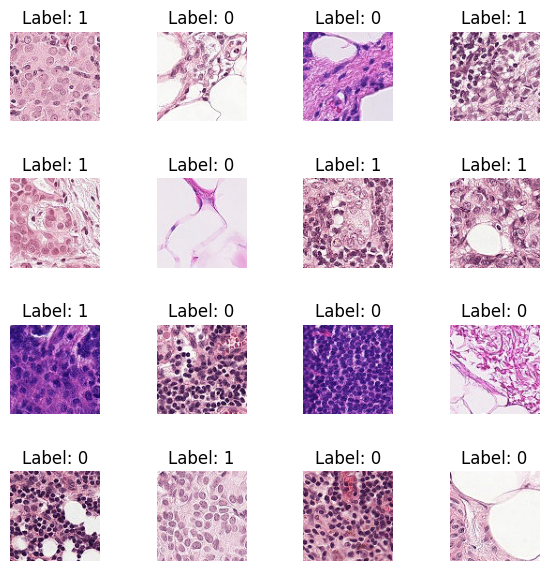

In [ ]:
# Sample 16 images and labels from the training set
sample_images = filtered_df.sample(16)

# Set up the figure and axes
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
fig.tight_layout(pad=1.0)

# Loop through the images and display each one with its label
for i, ax in enumerate(axes.flat):
    # Get the filename and label for each sample
    id = sample_images.iloc[i]['id']
    label = sample_images.iloc[i]['label']

    # Load the image from file
    img = mpimg.imread(os.path.join(train_images, id))

    # Display the image
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.show()

# Split into train and validation dataframes

In [ ]:
# Split the data into train_df and valid_df with stratified sampling
train_df, valid_df = train_test_split(
    filtered_df,
    test_size=0.2,               # 20% for validation
    stratify=filtered_df['label'],     # Stratify by the label column to preserve proportions
    random_state=42              # Set random seed for reproducibility
)

# Display the size of each dataset to confirm the split
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")

Training set size: 173864
Validation set size: 43466


# Ensure no data leakage between train and validation df

In [ ]:
print(len(set(train_df['id']).intersection(set(valid_df['id']))) == 0)  # Should return True

True


# Ensure even label distribution between train and validation images

<Figure size 800x500 with 0 Axes>

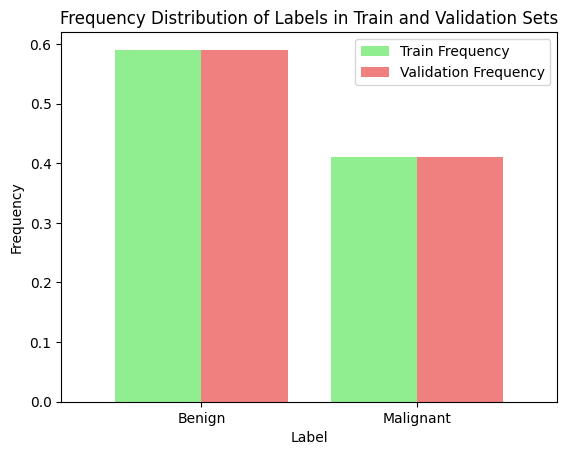

In [ ]:
# Calculate the frequencies for training and validation sets
train_frequency = (train_df.label.value_counts() / len(train_df)).to_frame('train_frequency')
valid_frequency = (valid_df.label.value_counts() / len(valid_df)).to_frame('valid_frequency')

# Merging the two dataframes to plot them side by side
frequency_df = pd.concat([train_frequency, valid_frequency], axis=1)

# Plotting the side-by-side bar chart
plt.figure(figsize=(8, 5))
frequency_df.plot(kind='bar', color=['lightgreen', 'lightcoral'], width=0.8)

# Customizing chart
plt.title('Frequency Distribution of Labels in Train and Validation Sets')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['Benign', 'Malignant'], rotation=0)
plt.legend(['Train Frequency', 'Validation Frequency'], loc='upper right')

# Show the plot
plt.show()

# Create data generator and loaders

In [ ]:
# Set batch size
BATCH_SIZE = 32

# Combined data generator with augmentations
train_datagen = ImageDataGenerator(
    rescale=1/255,                # Normalize pixel values to [0, 1]
    rotation_range=15,            # Rotate images by up to 15 degrees
    width_shift_range=0.3,        # Horizontal shift (up to 30%)
    height_shift_range=0.3,       # Vertical shift (up to 30%)
    horizontal_flip=True,         # Flip images horizontally
    zoom_range=0.2,               # Zoom in/out slightly
    fill_mode='reflect'           # Fill mode to handle shifts (options: 'nearest', 'constant', 'reflect', 'wrap')
)

# Flow the entire training dataframe
train_loader = train_datagen.flow_from_dataframe(
    dataframe=train_df,           # Full training dataframe
    directory=train_images,       # Directory with images
    x_col='id',                   # Column with image filenames
    y_col='label',                # Column with labels (0 or 1)
    class_mode='binary',          # Binary classification
    target_size=(96, 96),         # Resize images to 96x96
    batch_size=BATCH_SIZE,        # Batch size
    shuffle=True                  # Shuffle images during training
)

# Validation data generator (no augmentations)
valid_datagen = ImageDataGenerator(rescale=1/255)

valid_loader = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,           # Validation dataframe
    directory=train_images,       # Directory with images
    x_col='id',
    y_col='label',
    class_mode='binary',
    target_size=(96, 96),
    batch_size=BATCH_SIZE,
    shuffle=False                 # No shuffling for validation
)


Found 173864 validated image filenames belonging to 2 classes.
Found 43466 validated image filenames belonging to 2 classes.


In [ ]:
print(valid_df.head())
print(f"Total validation samples: {len(valid_df)}")


                                                  id label
79754   ea17ef71f6e9b59d80d1e6eb04a986c7e624a627.tif     0
167909  d6e71df6096398d296716dad929e3c378b0b801d.tif     1
115105  0e6b3da49be8314b6697cda7e834e8d1f9850dae.tif     1
199340  7f56514c19b2f7a063dde2980768dd22590d83e6.tif     0
117714  8598d4b329f0afaccccf4567aadd4c6d49b9f122.tif     0
Total validation samples: 43466


# Visualize Augmentation of Train Images

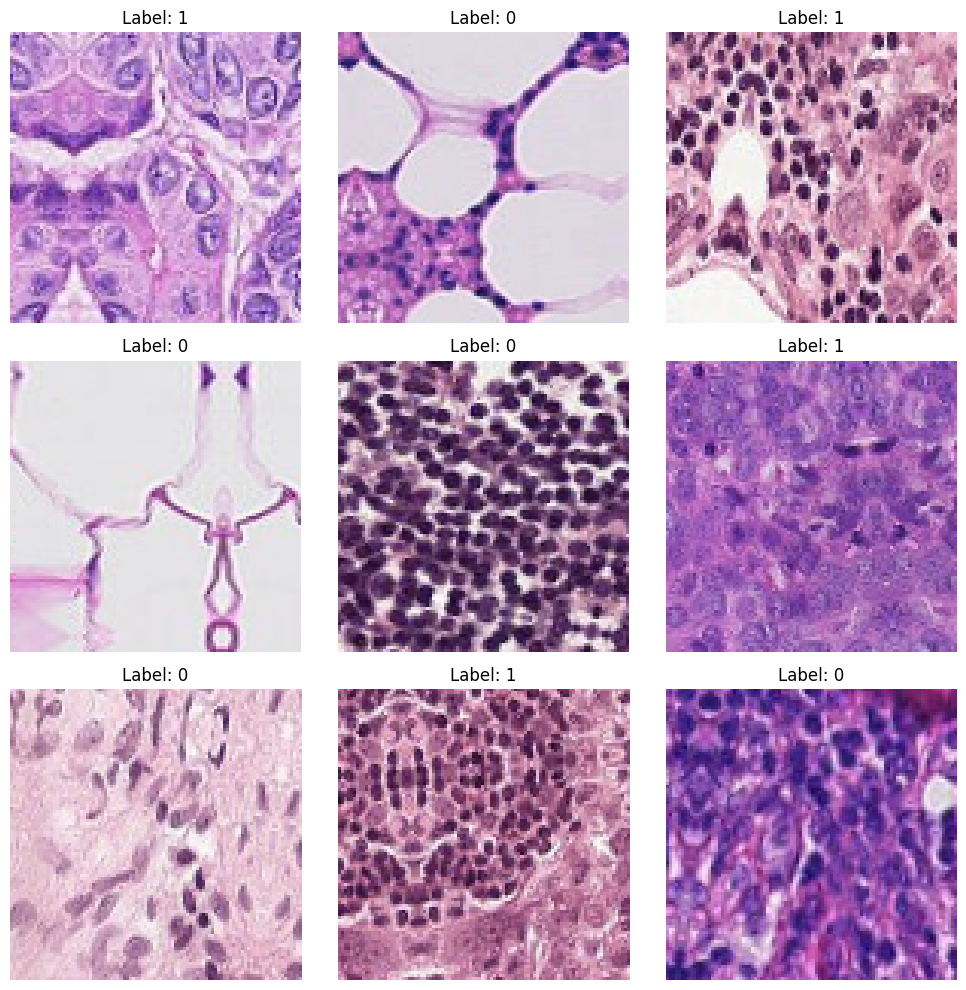

In [ ]:
# Fetch a batch of images and labels from the generator
augmented_images, labels = next(train_loader)

# Plot 9 images from the batch
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[i])  # Display each image
    plt.axis('off')
    plt.title(f"Label: {int(labels[i])}")  # Show label ID as title

plt.tight_layout()
plt.show()

# Determine number of steps

In [ ]:
TR_STEPS = len(train_loader)
VA_STEPS = len(valid_loader)

print(TR_STEPS)
print(VA_STEPS)

5434
1359


# Define SE Block for green channel

In [ ]:
@register_keras_serializable()
def se_block(input_tensor, ratio=16, name='se_block'):
    """ Squeeze-and-Excitation (SE) Block for channel attention.

    Args:
        input_tensor: Input feature map (4D tensor) with shape (batch, height, width, channels).
        ratio: Reduction ratio for the intermediate fully connected layers.
        name: Name of the SE block for easier identification in the model summary.

    Returns:
        Tensor after applying channel recalibration.
    """
    # Squeeze: Global Average Pooling
    channel_axis = -1  # Channels-last format
    filters = input_tensor.shape[channel_axis]
    se_shape = (1, 1, filters)  # Shape for the scaling tensor

    x = GlobalAveragePooling2D(name=f'{name}_squeeze')(input_tensor)
    x = Reshape(se_shape, name=f'{name}_reshape')(x)

    # Excite: Fully Connected Layers for Channel Attention
    x = Dense(filters // ratio, activation='relu', name=f'{name}_fc1')(x)  # Reduction
    x = Dense(filters, activation='sigmoid', name=f'{name}_fc2')(x)        # Scaling

    # Scale: Multiply attention weights with input feature maps
    x = Multiply(name=f'{name}_scale')([input_tensor, x])
    return x


# Define CBAM class and define model

In [ ]:
@register_keras_serializable()
class CBAM(Layer):
    def __init__(self, channels, reduction_ratio=16, **kwargs):
        super(CBAM, self).__init__(**kwargs)
        self.channels = channels
        self.reduction_ratio = reduction_ratio

        # Channel attention layers
        self.global_avg_pool = GlobalAveragePooling2D()
        self.global_max_pool = GlobalMaxPooling2D()
        self.fc1 = Dense(channels // reduction_ratio, activation='relu')
        self.fc2 = Dense(channels, activation='sigmoid')

        # Spatial attention layers
        self.conv = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')

    def build(self, input_shape):
        # Ensure variables are built once
        self.reshape_layer = Reshape((1, 1, self.channels))
        self.concat_layer = Concatenate(axis=-1)
        self.multiply_layer = Multiply()

    def call(self, inputs):
        # Channel Attention
        avg_out = self.global_avg_pool(inputs)
        max_out = self.global_max_pool(inputs)
        avg_out = self.fc2(self.fc1(self.reshape_layer(avg_out)))
        max_out = self.fc2(self.fc1(self.reshape_layer(max_out)))
        channel_attention = self.multiply_layer([inputs, avg_out + max_out])

        # Spatial Attention
        avg_pool = tf.reduce_mean(channel_attention, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(channel_attention, axis=-1, keepdims=True)
        spatial_attention = self.conv(self.concat_layer([avg_pool, max_pool]))
        return self.multiply_layer([channel_attention, spatial_attention])

    def get_config(self):
        config = super(CBAM, self).get_config()
        config.update({
            "channels": self.channels,
            "reduction_ratio": self.reduction_ratio
        })
        return config


In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

def create_cbam_se_cnn():
    inputs = tf.keras.Input(shape=(96, 96, 3))

    # First convolutional block
    x = Conv2D(32, (3, 3), padding='same')(inputs)
    x = se_block(x, ratio=4, name='se_block_1')  # Add SE block
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Second convolutional block
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = se_block(x, ratio=4, name='se_block_2')  # Add SE block
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = CBAM(64)(x)  # CBAM Block
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Third convolutional block
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = se_block(x, ratio=4, name='se_block_3')  # Add SE block
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    # Fourth convolutional block
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = se_block(x, ratio=4, name='se_block_4')  # Add SE block
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = CBAM(256)(x)  # CBAM Block
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    # Global Average Pooling instead of Flatten
    x = GlobalAveragePooling2D()(x)

    # Dense layers with L2 regularization
    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Output layer for binary classification
    outputs = Dense(1, activation='sigmoid')(x)  # Adjusted for binary classification

    # Model
    cnn = tf.keras.Model(inputs=inputs, outputs=outputs)
    return cnn


cnn = create_cbam_se_cnn()
cnn.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 96, 96, 32)     │            896 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ se_block_1_squeeze        │ (None, 32)             │              0 │ conv2d_12[0][0]        │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ se_block_1_reshape        │ (None, 1, 1, 32)       │              0 │ se_block_1_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ se_block_1_fc1 (Dense)    │ (None, 1, 1, 8)        │            264 │ se_block_1_reshape[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ se_block_1_fc2 (Dense)    │ (None, 1, 1, 32)       │            288 │ se_block_1_fc1[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ se_block_1_scale          │ (None, 96, 96, 32)     │              0 │ conv2d_12[0][0],       │
│ (Multiply)                │                        │                │ se_block_1_fc2[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 96, 96, 32)     │            128 │ se_block_1_scale[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_8 (LeakyReLU) │ (None, 96, 96, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 48, 48, 32)     │              0 │ leaky_re_lu_8[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 48, 48, 32)     │              0 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 48, 48, 64)     │         18,496 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ se_block_2_squeeze        │ (None, 64)             │              0 │ conv2d_13[0][0]        │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ se_block_2_reshape        │ (None, 1, 1, 64)       │              0 │ se_block_2_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ se_block_2_fc1 (Dense)    │ (None, 1, 1, 16)       │          1,040 │ se_block_2_reshape[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ se_block_2_fc2 (Dense

 Total params: 485,683 (1.85 MB)

 Trainable params: 484,339 (1.85 MB)

 Non-trainable params: 1,344 (5.25 KB)

# Define optimizer, assign class weighting and compile model

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Custom metric for Malignant Recall
def malignant_recall(y_true, y_pred):
    y_pred_classes = K.round(y_pred)  # Convert probabilities to binary (0 or 1)
    true_positives = K.sum(K.cast(y_true * y_pred_classes, 'float32'))  # TP for class 1
    total_actual_positives = K.sum(K.cast(y_true, 'float32'))  # Total positives
    return true_positives / (total_actual_positives + K.epsilon())


In [ ]:
# Define the optimizer
learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model
cnn.compile(optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=[tf.keras.metrics.AUC(name='auc'), malignant_recall])


# Determine Class Weights

In [ ]:
# Get class labels and calculate weights
class_labels = train_df['label']  # Replace with actual training labels
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)

# Convert to a dictionary
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.8469272436771755, 1: 1.2206121875877562}


# Train model

In [ ]:
from tensorflow.keras.callbacks import Callback

class MonitorMalignantRecall(Callback):
    def on_epoch_end(self, epoch, logs=None):
        recall = logs.get('malignant_recall')  # Fetch the recall metric
        val_recall = logs.get('val_malignant_recall')  # Fetch validation recall
        print(f"Epoch {epoch+1} - Malignant Recall: {recall:.4f}, Val Recall: {val_recall:.4f}")


In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=3, verbose=1)
model_checkpoint = ModelCheckpoint("best_cbam_model.keras", save_best_only=True, monitor="val_auc")
malignant_recall_monitor = MonitorMalignantRecall()  # Custom callback

# Train the model
history = cnn.fit(
    train_loader,
    validation_data=valid_loader,
    epochs=30,
    callbacks=[early_stop, lr_scheduler, model_checkpoint, malignant_recall_monitor],
    class_weight=class_weights_dict,
    verbose=1
)




Epoch 1/30
5432/5434 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - auc: 0.8218 - loss: 0.7588 - malignant_recall: 14.7770Epoch 1 - Malignant Recall: 14.2654, Val Recall: 15.4084
5434/5434 ━━━━━━━━━━━━━━━━━━━━ 597s 105ms/step - auc: 0.8218 - loss: 0.7587 - malignant_recall: 14.7767 - val_auc: 0.8728 - val_loss: 0.6752 - val_malignant_recall: 15.4084 - learning_rate: 1.0000e-04
Epoch 2/30
5432/5434 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - auc: 0.8962 - loss: 0.5235 - malignant_recall: 13.9753Epoch 2 - Malignant Recall: 13.9928, Val Recall: 16.5232
5434/5434 ━━━━━━━━━━━━━━━━━━━━ 545s 100ms/step - auc: 0.8962 - loss: 0.5234 - malignant_recall: 13.9753 - val_auc: 0.9124 - val_loss: 0.5144 - val_malignant_recall: 16.5232 - learning_rate: 1.0000e-04
Epoch 3/30
5432/5434 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - auc: 0.9201 - loss: 0.4122 - malignant_recall: 13.8703Epoch 3 - Malignant Recall: 13.8842, Val Recall: 17.0081
5434/5434 ━━━━━━━━━━━━━━━━━━━━ 544s 100ms/step - auc: 0.9201 - loss: 0.4122 - malignant_recall

# Plot results

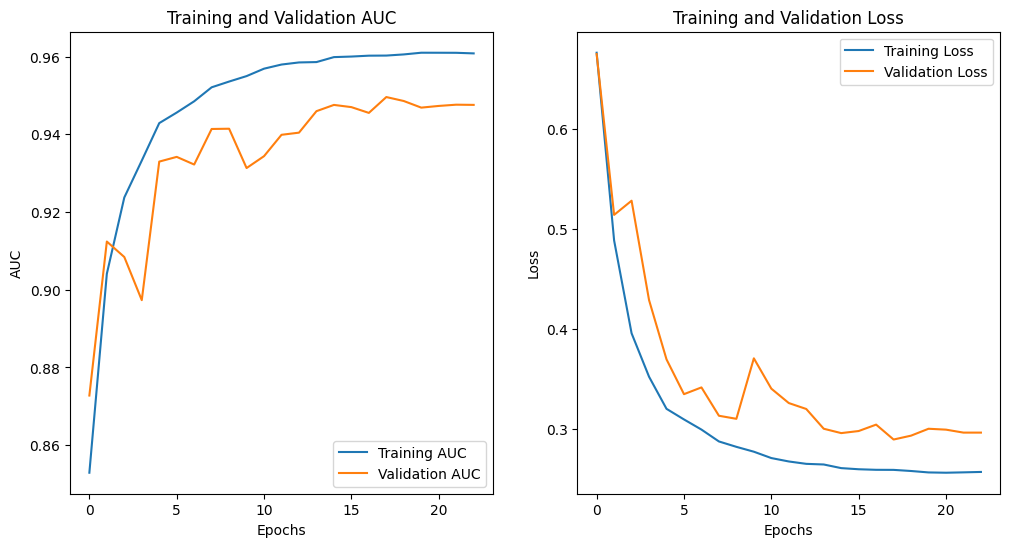

In [ ]:
# Plot the training and validation accuracy and loss curves
def plot_training_curves(history):
    # Get training and validation metrics
    auc = history.history['auc']
    val_auc = history.history['val_auc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(auc))

    plt.figure(figsize=(12, 6))

    # Plot AUC
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, auc, label='Training AUC')
    plt.plot(epochs_range, val_auc, label='Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend(loc='lower right')
    plt.title('Training and Validation AUC')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

# Call the function to display the curves
plot_training_curves(history)

# Confusion Matrix and Classification Report

1359/1359 ━━━━━━━━━━━━━━━━━━━━ 31s 23ms/step


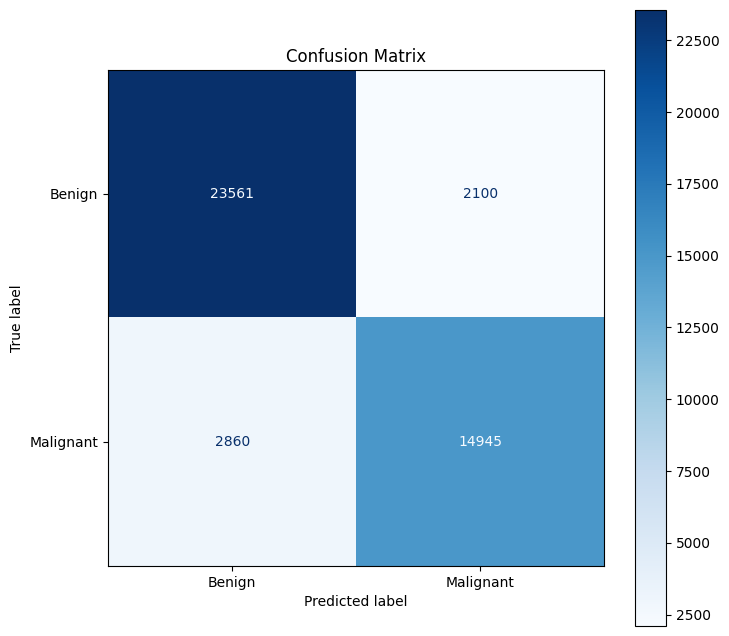

Classification Report:
              precision    recall  f1-score   support

      Benign       0.89      0.92      0.90     25661
   Malignant       0.88      0.84      0.86     17805

    accuracy                           0.89     43466
   macro avg       0.88      0.88      0.88     43466
weighted avg       0.89      0.89      0.89     43466



In [41]:
# Define class names for labels
class_names = ["Benign", "Malignant"]

# Get true labels from validation set
y_true = valid_loader.labels  # True labels from validation generator

# Predict probabilities for the validation set
y_pred_prob = cnn.predict(valid_loader)  # Predicted probabilities

# Convert probabilities to binary class predictions
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Binary classification threshold

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=True)

plt.title("Confusion Matrix")
plt.show()

# Generate the precision-recall report
print("Classification Report:")
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


# Save Model

In [ ]:
cnn.save('/content/drive/My Drive/121124v2.keras')
pickle.dump(history, open('/content/drive/My Drive/121124v2.pkl', 'wb'))